<a href="https://colab.research.google.com/github/cosimo-schiavoni/Massive_Data_Project/blob/main/Downloads_TF_DISTR_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
!nvidia-smi

Mon Jul  4 17:20:43 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [33]:
!wget -q https://www-eu.apache.org/dist/spark/spark-3.2.1/spark-3.2.1-bin-hadoop2.7.tgz
!tar xf spark-3.2.1-bin-hadoop2.7.tgz
!rm spark-3.2.1-bin-hadoop2.7.tgz
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!pip install findspark
!pip install pyspark
!pip install -q kaggle
#!pip install elephas
!pip install sparkdl
!pip install tensorframes
!pip install petastorm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.3 MB 45 kB/s 
     |████████████████████████████████| 199 kB 65.8 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.0-py2.py3-none-any.whl size=281764026 sha256=ddf6a090d29d6fe3304fb8e5c18dbbdb7ad8ef3dfe31863e200dd355834f1fcc
  Stored in directory: /root/.cache/pip/wheels/7a/8e/1b/f73a52650d2e5f337708d9f6a1750d451a7349a867f928b885
Successfully built pyspark
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 99 kB 5.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████|

In [34]:
import pyspark
# Spark Session, Pipeline, Functions, and Metrics
from pyspark import SparkContext, SparkConf
from pyspark.sql import SQLContext
from pyspark.ml.feature import OneHotEncoder, StringIndexer, StandardScaler, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.sql.functions import rand
from pyspark.mllib.evaluation import MulticlassMetrics

# Keras / Deep Learning
import tensorflow as tf
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras import optimizers, regularizers
from tensorflow.keras.optimizers import Adam

# Elephas for Deep Learning on Spark
#from elephas.ml_model import ElephasEstimator

In [35]:
from pyspark.sql import SparkSession
from pyspark.ml.image import ImageSchema
from pyspark.sql.functions import lit
from functools import reduce
from google.colab import files
import os
import zipfile
import findspark
from pyspark.sql.functions import col
from petastorm import TransformSpec
from petastorm.spark import SparkDatasetConverter, make_spark_converter
import numpy as np

#from my model
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
import pickle
import shutil
import random
import skimage.io as io
from copy import deepcopy



/usr/local/lib/python3.7/dist-packages/petastorm/spark/spark_dataset_converter.py:28: FutureWarning: pyarrow.LocalFileSystem is deprecated as of 2.0.0, please use pyarrow.fs.LocalFileSystem instead.
  from pyarrow import LocalFileSystem


In [36]:
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

import kaggle
from kaggle.api.kaggle_api_extended import KaggleApi

Saving kaggle.json to kaggle.json


In [37]:
os.environ["data_source"] = "./Face_Comics_data"

api = KaggleApi()
api.authenticate()

if not os.path.exists(os.environ["data_source"]):
  os.makedirs(os.environ["data_source"])
  if "comic-faces-paired-synthetic-v2" not in os.listdir():
    if "comic-faces-paired-synthetic-v2.zip" not in os.listdir():
      ! kaggle datasets download -d defileroff/comic-faces-paired-synthetic-v2
      with zipfile.ZipFile("comic-faces-paired-synthetic-v2.zip", 'r') as f:
        f.extractall("comic-faces-paired-synthetic-v2")
    os.remove("comic-faces-paired-synthetic-v2.zip")


!mv "./comic-faces-paired-synthetic-v2/face2comics_v2.0.0_by_Sxela/face2comics_v2.0.0_by_Sxela/comics" "./Face_Comics_data"
!mv "./comic-faces-paired-synthetic-v2/face2comics_v2.0.0_by_Sxela/face2comics_v2.0.0_by_Sxela/faces" "./Face_Comics_data"

!rm -rf comic-faces-paired-synthetic-v2

100% 2.17G/2.18G [00:19<00:00, 140MB/s]
100% 2.18G/2.18G [00:19<00:00, 122MB/s]


In [48]:
#data augmentation

@tf.function
def random_invert_img(x, p=0.5):
  if  tf.random.uniform([]) < p:
    x = (180-x)
  else:
    x
  return x

###Randim invert
@tf.function 
def random_invert(factor=0.5):
  return layers.Lambda(lambda x: random_invert_img(x, factor))

#@tf.function 
class RandomInvert(layers.Layer):
  @tf.function 
  def __init__(self, factor=0.5, **kwargs):
    super().__init__(**kwargs)
    self.factor = factor
  @tf.function 
  def call(self, x):
    return random_invert_img(x)


###Kernel Inizializer Sobel_x
@tf.function 
def hedge_detector(shape, dtype=None):
    print(shape)    
    sobel_x = tf.constant(
        [
            [-5, -4, 0, 4, 5], 
            [-8, -10, 0, 10, 8], 
            [-10, -20, 0, 20, 10], 
            [-8, -10, 0, 10, 8], 
            [-5, -4, 0, 4, 5]
        ], dtype=dtype )
    #create the missing dims.
    sobel_x = tf.reshape(sobel_x, (5, 5, 1, 1))

    print(tf.shape(sobel_x))
    #tile the last 2 axis to get the expected dims.
    sobel_x = tf.tile(sobel_x, (1, 1, shape[-2],shape[-1]))

    print(tf.shape(sobel_x))
    return sobel_x

@tf.function 
def vertical_detector(shape, dtype=None):
    print(shape)    
    sobel_x = tf.constant(
        [
            [1, 0, -1], 
            [1, 0, -1], 
            [1, 0, -1]
        ], dtype=dtype )
    #create the missing dims.
    sobel_x = tf.reshape(sobel_x, (3, 3, 1, 1))

    print(tf.shape(sobel_x))
    #tile the last 2 axis to get the expected dims.
    sobel_x = tf.tile(sobel_x, (1, 1, shape[-2],shape[-1]))

    print(tf.shape(sobel_x))
    return sobel_x

@tf.function 
def horizontal_detector(shape, dtype=None):
    print(shape)    
    sobel_x = tf.constant(
        [
            [1, 1, 1], 
            [0, 0, 0], 
            [-1, -1, -1]
        ], dtype=dtype )
    #create the missing dims.
    sobel_x = tf.reshape(sobel_x, (3, 3, 1, 1))

    print(tf.shape(sobel_x))
    #tile the last 2 axis to get the expected dims.
    sobel_x = tf.tile(sobel_x, (1, 1, shape[-2],shape[-1]))

    print(tf.shape(sobel_x))
    return sobel_x

In [63]:

def get_compiled_model():
    # Make a simple 2-layer densely-connected neural network.
        ###Create CNN
    #Initialize the CNN
    cnn = tf.keras.models.Sequential()
      
    cnn.add(tf.keras.Sequential([
      layers.RandomFlip("horizontal_and_vertical"),
      layers.RandomRotation(0.3),
        layers.RandomContrast(0.5, seed=None),
        RandomInvert(),
        layers.RandomZoom(height_factor=(-0.2, +0.3)),
        layers.RandomTranslation(height_factor=(-0.2, +0.3),width_factor=(-0.2, +0.3)),
        layers.Rescaling(1./255, offset= -1)
        ]))
    
    #DROPOUT
    #Introduce the Convolution layer with Kernel_initializer=Sobel_x
    #Convolution
    cnn.add(tf.keras.layers.Conv2D(32, kernel_size=5, strides=2, activation='relu',  input_shape = [350,350,3]))
    #Pooling
    cnn.add(tf.keras.layers.MaxPool2D(pool_size = 2, strides = 2))
    #Convolution
    cnn.add(tf.keras.layers.Conv2D(filters = 32, kernel_size = 3,  strides=2, activation = 'relu'))
    #Pooling
    cnn.add(tf.keras.layers.MaxPool2D(pool_size = 2, strides = 2))
    #Second Convolutional Layer
    cnn.add(tf.keras.layers.Conv2D(filters = 32, kernel_size = 2,  strides=2, activation = 'relu'))
    cnn.add(tf.keras.layers.MaxPool2D(pool_size = 2, strides=1, padding='same'))
    #Third Convolutional Layer
    #cnn.add(tf.keras.layers.Conv2D(filters = 32, kernel_size = 2, activation = 'relu'))
    #cnn.add(tf.keras.layers.MaxPool2D(pool_size = 2, strides=2))
    #Flattening
    cnn.add(tf.keras.layers.Flatten())
        #Full Connection
    cnn.add(tf.keras.layers.Dense(units = 128, activation = 'relu'))
    #DROPOUTS ok(0.1)
    cnn.add(tf.keras.layers.Dropout(0.1))
    #Output Layer
    cnn.add(tf.keras.layers.Dense(units=1, activation = 'sigmoid'))
    ###Training CNN
    #Compiling the CNN
    cnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    return cnn


def get_dataset():
    BUFFER_SIZE = 10000

    BATCH_SIZE_PER_REPLICA = 64
    BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync

    data_dir= "./Face_Comics_data"

    tf.random.set_seed(123456)

    EPOCHS = 15
    #BATCH_SIZE = 32
    #IMG_SIZE = (160, 160)
    IMG_SIZE = (350, 350)

    os.listdir(data_dir)


    train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
        data_dir,
        validation_split=0.3,
        subset="training",
        shuffle=True,
        seed=123456,
        image_size= IMG_SIZE,
        batch_size=BATCH_SIZE)


    validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
        data_dir,
        validation_split=0.4,
        subset="validation",
        shuffle=True,
        seed=123456,
        image_size= IMG_SIZE,
        batch_size=BATCH_SIZE)
    
    val_batches = tf.data.experimental.cardinality(validation_dataset)
    test_dataset = validation_dataset.take(val_batches // 5)
    validation_dataset = validation_dataset.skip(val_batches // 5)
    print('Number of training batches: %d' % tf.data.experimental.cardinality(train_dataset))
    print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
    print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

    AUTOTUNE = tf.data.AUTOTUNE

    train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
    validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
    test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

    return (
        train_dataset,
        validation_dataset,
        test_dataset
    )




In [40]:
# Create a MirroredStrategy.
strategy = tf.distribute.MirroredStrategy()
print("Number of devices: {}".format(strategy.num_replicas_in_sync))


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of devices: 1


In [64]:

# Open a strategy scope.
with strategy.scope():
    # Everything that creates variables should be under the strategy scope.
    # In general this is only model construction & `compile()`.
    model = get_compiled_model()


In [65]:

# Train the model on all available devices.
train_dataset, validation_dataset, test_dataset = get_dataset()
model_fit = model.fit(train_dataset, epochs=15, validation_data=validation_dataset)
model_fit

Found 20000 files belonging to 2 classes.
Using 14000 files for training.
Found 20000 files belonging to 2 classes.
Using 8000 files for validation.
Number of training batches: 219
Number of validation batches: 100
Number of test batches: 25
Epoch 1/15
219/219 [==============================] - 108s 464ms/step - loss: 0.6310 - accuracy: 0.6139 - val_loss: 0.4232 - val_accuracy: 0.7905
Epoch 2/15
219/219 [==============================] - 102s 459ms/step - loss: 0.4410 - accuracy: 0.7935 - val_loss: 0.3316 - val_accuracy: 0.8548
Epoch 3/15
219/219 [==============================] - 103s 460ms/step - loss: 0.4533 - accuracy: 0.7884 - val_loss: 0.2908 - val_accuracy: 0.9098
Epoch 4/15
219/219 [==============================] - 103s 464ms/step - loss: 0.2575 - accuracy: 0.8926 - val_loss: 0.2514 - val_accuracy: 0.8783
Epoch 5/15
219/219 [==============================] - 103s 459ms/step - loss: 0.2204 - accuracy: 0.9126 - val_loss: 0.0637 - val_accuracy: 0.9817
Epoch 6/15
219/219 [========

In [66]:

# Test the model on all available devices.
model.evaluate(test_dataset)

25/25 [==============================] - 9s 293ms/step - loss: 0.0069 - accuracy: 0.9969


[0.006878896150738001, 0.996874988079071]

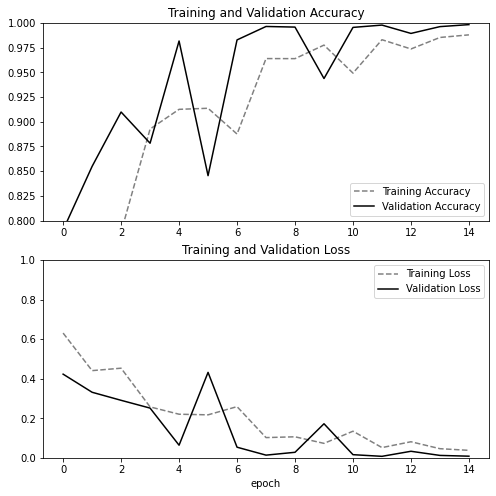

In [67]:
#There are two variable objects. Divided between around 2.5 million of MobilNet parameters which 
#are frozen, and 1.2 thousand of trainable parameter in the Dense layer
#len(cnn.trainable_variables)

acc = model_fit.history['accuracy']
val_acc = model_fit.history['val_accuracy']
loss_ = model_fit.history['loss']
val_loss_ = model_fit.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy', color = 'gray',linestyle='dashed')
plt.plot(val_acc, label='Validation Accuracy', color = 'black')
plt.ylim([0.8, 1])
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss_, label='Training Loss', color = 'gray',linestyle='dashed')
plt.plot(val_loss_, label='Validation Loss', color = 'black')
plt.ylim([0, 1.0])
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()
